# Creating synthetic Titanic passenger data with SMOTE

Synthetic data may be useful to share when it is not possible to share original data.

Here we use original Titanic passenger data to create new synthetic passenger data. We then train a logistic model on that synthetic data and test on real data that was not used to create the synthetic data.

## Description of SMOTE

SMOTE stands for Synthetic Minority Oversampling Technique [1]. SMOTE is more commonly used to create additional data to enhance modelling fitting, especially when one or more classes have low prevalence in the data set. Hence the description of oversampling.

SMOTE works by finding near-neighbor points in the original data, and creating new data points from interpolating between two near-neighbor points.

Here we remove the real data used to create the synthetic data, leaving only the synthetic data. After generating synthetic data we remove any data points that, by chance, are identical to original real data points, and also remove 10% of points that are closest to the original data points. We measure ‘closeness’ by the Cartesian distance between standardised data values.

![](./images/smote.png)

*Demonstration of SMOTE method. (a) Data points with two features (shown on x and y axes) are represented. Points are colour-coded by class label. (b) A data point from a class is picked at random, shown by the black point, and then the closest neighbours of the same class are identified, as shown by yellow points. Here we show 3 closest neighbours, but the default in the SMOTE `Imbalanced-Learn` library is 6. One of those near-neighbour points is selected at random (shown by the second black point). A new data point, shown in red, is created at a random distance between the two selected data points.*

### Handling integer, binary, and categorical data

The standard SMOTE method generates floating point non-integer) values between data points. There are alternative ways of handing integer, binary, and categorical data using the SMOTE method. Here the methods we use are:

* *Integer* values: Round the resulting synthetic data point value to the closest integer.

* *Binary*: Code the value as 0 or 1, and round the resulting synthetic data point value to the closest integer (0 or 1).

* *Categorical*: One-hot encode the categorical feature. Generate the synthetic data for each category value. Identify the category with the highest value and set to 1 while setting all others to 0.

### Implementation with IMBLEARN

Here use the implementation in the IMBLEARN IMBALANCED-LEARN [2] 

[1] Chawla, N.V., Bowyer, K.W., Hall, L.O., Kegelmeyer, W.P. “SMOTE: Synthetic minority over-sampling technique,” Journal of Artificial Intelligence Research, vol. 16, pp. 321-357, 2002.

[2] Lemaitre, G., Nogueira, F. and Aridas, C. (2016), Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning. arXiv:1609.06570 (https://pypi.org/project/imbalanced-learn/, `pip install imbalanced-learn`).


## Overview of code sections

Below is an outline of this notebook.

1. Load packages
1. Load and process data
    1. Load data
    1. Divide into X (features) and y (labels)
    1. Divide into training and test sets
    1. Standardise data
1. Fit and test logistic regression model on real data
    1. Fit model
    1. Predict values
    1. Calculate accuracy
1. Make Synthetic data
    1. Function to create synthetic data
    1. Generate raw synthetic data
    1. Processing of raw synthetic data
        1. Prepare lists of categorical, integer, and binary features
        1. Function to process raw synthetic categorical data to one-hot encoded
        1. Process raw synthetic data
    1. Remove synthetic data that is a duplication of original data or close to original data
        1. Remove identical points
        1. Remove closest points to original data
    1. Show five examples with their closest data points in the original data
    1. Sample from synthetic data to get same size/balance as the original data
    1. Examine distances between synthetic-real and real-real near neighbours
1. Comparison of real and synthetic data
1. Test synthetic data for training a logistic regression model
    1. Fit model using synthetic data and check accuracy
    1. Receiver Operator Characteristic curves

## Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.neighbors import NearestNeighbors

# Import package for SMOTE
import imblearn

# Turn warnings off to keep notebook clean
import warnings
warnings.filterwarnings("ignore")

## Load and process data

### Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://michaelallen1966.github.io/titanic/01_preprocessing.html

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type and drop Passenger ID
data = data.astype(float)
data.drop('PassengerId', axis=1, inplace=True) # Remove passenger ID

In [4]:
# Record number in each class
number_died = np.sum(data['Survived'] == 0)
number_survived = np.sum(data['Survived'] == 1)

### Divide into X (features) and y (labels)

In [5]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

### Divide into training and test sets

To demonstrate the method we will use a single train/test split for simplicity.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Show examples from the training data.

In [7]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,CabinNumberImputed,...,Embarked_missing,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing
612,3.0,28.0,1.0,0.0,15.5000,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
118,1.0,24.0,0.0,1.0,247.5208,0.0,0.0,0.0,58.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707,1.0,42.0,0.0,0.0,26.2875,0.0,0.0,0.0,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
888,3.0,28.0,1.0,2.0,23.4500,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
204,3.0,18.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Standardise data

To standardise the data we subtract the mean of the training set values, and divide by the standard deviation of the training data. Note that the mean and standard deviation of the training data are used to standardise the test set data as well. Here we use sklearn's `StandardScaler` method.

In [8]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [9]:
X_train_std, X_test_std = standardise_data(X_train, X_test)

## Fit and test logistic regression model on real data

### Fit model

We will fit a logistic regression model, using sklearn's `LogisticRegression` method. 

In [10]:
model = LogisticRegression()
model.fit(X_train_std,y_train)

LogisticRegression()

### Predict values

Now we can use the trained model to predict survival. We will test the accuracy of both the training and test data sets.

In [11]:
# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

### Calculate accuracy

Here we measure accuracy simply as the proportion of passengers where we make the correct prediction (later we will use Receiver Operator Characteristic curves for a more thorough analysis).

In [12]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:0.3f}')
print (f'Accuracy of predicting test data = {accuracy_test:0.3f}')

Accuracy of predicting training data = 0.828
Accuracy of predicting test data = 0.758


## Make Synthetic data

### Function to create synthetic data

This function is to make synethetic data for two classes.

In [13]:
def make_synthetic_data_smote(X, y, number_of_samples=[1000,1000]):
    """
    Synthetic data generation for two classes.
        
    Inputs
    ------
    original_data: X, y numpy arrays (y should have label 0 and 1)
    number_of_samples: number of samples to generate (list for y=0, y=1)
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
    
    from imblearn.over_sampling import SMOTE
    
    # Count instances in each class
    count_label_0 = np.sum(y==0)
    count_label_1 = np.sum(y==1)
    
    # SMOTE requires final class counts; add current counts to required counts
    n_class_0 = number_of_samples[0] + count_label_0
    n_class_1 = number_of_samples[1] + count_label_1

    # Get SMOTE points
    X_resampled, y_resampled = SMOTE(
        sampling_strategy = {0:n_class_0, 1:n_class_1}).fit_resample(X, y)

    # Get just the additional (synethetic) data points
    X_synthetic = X_resampled[len(X):]
    y_synthetic = y_resampled[len(y):]
                                                                   
    return X_synthetic, y_synthetic

We will generate twice as much raw synthetic data for each class as the current data has. This will allow us to remove points that are identical to, or close to, original data.

### Generate raw synthetic data

In [14]:
# Get counts fo classes from y_train
unique, original_frequency = np.unique(y_train, return_counts = True)
required_smote_count = list(original_frequency * 2)

In [15]:
X_synthetic, y_synthetic = make_synthetic_data_smote(
        X_train, y_train, number_of_samples=required_smote_count)

### Processing of raw synthetic data

#### Prepare lists of categorical, integer, and binary features

These lists will be used to process raw syenthetic data to the appropriate data type.

In [16]:
# Get full list of column names
X_col_names = list(X_train)

# Set categorical one-hots cols using common prefix 
categorical = ['Embarked_', 'CabinLetter_']
one_hot_cols = []
for col in categorical:
    one_hot_cols.append([x for x in X_col_names if x[0:len(col)] == col])

# Set integer columns
integer_cols = ['Pclass',
                'Age',
                'Parch',
                'Fare',
                'SibSp',
                'CabinNumber']

# Set binary columns
binary_cols = ['male',
               'AgeImputed',
               'EmbarkedImputed',
               'CabinNumberImputed']

#### Function to process raw synthetic categorical data to one-hot encoded

Sets highest value to 1 and all others to 0.

In [17]:
def make_one_hot(x):
    """
    Takes a list/array/series and returns 1 for highest value and 0 for all 
    others
    
    """
    # Get argmax
    highest = np.argmax(x)
    # Set all values to zero
    x *= 0.0
    # Set argmax to one
    x[highest] = 1.0
    
    return x

#### Process raw synthetic data:

1. Transfer data to a DataFrame and add column names
1. Process one-hot categorical data fields
1. Process integer data fields
1. Process binary data fields
1. Add *y* data with label
1. Shuffle data

In [18]:
# Set y_label
y_label = 'Survived'

# Create a data frame with id
synth_df = pd.DataFrame()

# Transfer X values to DataFrame
synth_df=pd.concat([synth_df, 
                    pd.DataFrame(X_synthetic, columns=X_col_names)],
                    axis=1)

# Make one hot as necessary
for one_hot_list in one_hot_cols:    
    for index, row in synth_df.iterrows():
        x = row[one_hot_list]
        x_one_hot = make_one_hot(x)
        row[x_one_hot.index]= x_one_hot.values

# Make integer as necessary
for col in integer_cols:
    synth_df[col] = synth_df[col].round(0)

# Round and clip binary cols
for col in binary_cols:
    synth_df[col] = synth_df[col].round(0)
    synth_df[col] = np.clip(synth_df[col],0,1)
    
# Add y data with a label
y_list = list(y_synthetic)
synth_df[y_label] = y_list

# Shuffle data
synth_df = synth_df.sample(frac=1.0)

Show sample of synethetic data

In [19]:
synth_df.head()

,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,CabinNumberImputed,...,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing,Survived
1008,2.0,19.0,0.0,0.0,11.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1549,1.0,32.0,1.0,1.0,436.0,0.0,0.0,0.0,42.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1096,1.0,43.0,1.0,0.0,67.0,0.0,0.0,0.0,36.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1162,3.0,20.0,0.0,0.0,9.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1435,3.0,47.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Remove synthetic data that is a duplication of original data or close to original data

For each synethetic data point find nearest neighbour in the real data set (based on Cartesian distance of standardised data)

In [20]:
# Standardise synthetic data (based on real training data)
X_train_std, X_synth_std = standardise_data(X_train, X_synthetic)

# Get all real X data (combine standardised training + test data)
X_real_std = np.concatenate([X_train_std, X_test_std], axis=0)
  
# Use ScitLearn neighbors.NearestNeighbors to get nearest neighbour
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_real_std)
dists, idxs = nn.kneighbors(X_synth_std)

# Store in synthetic data DataFrame
synth_df['distance_to_closest_real'] = list(dists.flatten())
synth_df['closest_X_real_row_index'] = list(idxs.flatten())

In [21]:
synth_df

,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,CabinNumberImputed,...,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing,Survived,distance_to_closest_real,closest_X_real_row_index
1008,2.0,19.0,0.0,0.0,11.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,353
1549,1.0,32.0,1.0,1.0,436.0,0.0,0.0,0.0,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,21
1096,1.0,43.0,1.0,0.0,67.0,0.0,0.0,0.0,36.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.240925,164
1162,3.0,20.0,0.0,0.0,9.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000060,692
1435,3.0,47.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.315861,338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,3.0,17.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.098494,542
947,3.0,32.0,1.0,0.0,15.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.755892,24
1770,1.0,33.0,1.0,0.0,47.0,0.0,0.0,0.0,119.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000115,558
1483,1.0,47.0,0.0,1.0,135.0,0.0,0.0,0.0,71.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.934529,255


#### Remove identical points

In [22]:
# Get points with zero distance to real (use distance of <0.01 as effectively identical)
identical = synth_df['distance_to_closest_real'] < 0.01
print (f'Proportion of data points identical to real data points = {identical.mean():0.3f}')
# Remove points with zero distance to real
mask = identical == False
synth_df = synth_df[mask]

Proportion of data points identical to real data points = 0.211


#### Remove closest points to original data

Remove 10% of points that are closest to original data

In [23]:
# Proportion of points to remove
proportion_to_remove = 0.1

# Sort by distance 
synth_by_distance = synth_df.sort_values(
    'distance_to_closest_real', ascending=False)

# Limit data
number_to_keep = int(len(synth_by_distance) * (1 - proportion_to_remove))
synth_by_distance = synth_by_distance.head(number_to_keep)

# Shuffle and store back in synth_df
synth_df = synth_by_distance.sample(frac=1)

### Show five examples with their closest data points in the original data

In [24]:
# Reproduce X_real but with non-standardised values for comparison
X_real = np.concatenate([X_train, X_test], axis=0)

# Set up Data Frame for comparison
comparison = pd.DataFrame(index=X_col_names)

# Generate five examples
for i in range(5):
    # Get synthetic data sample
    sample = synth_df.sample(1)
    comparison[f'Synthetic_{i+1}'] = sample[X_col_names].values[0]
    # Get closest poitn from the real data
    closest_id = sample['closest_X_real_row_index']
    comparison[f'Synthetic_{i+1}_closest'] = X_real[closest_id, :][0]
    
# Display
comparison.round(0)

,Synthetic_1,Synthetic_1_closest,Synthetic_2,Synthetic_2_closest,Synthetic_3,Synthetic_3_closest,Synthetic_4,Synthetic_4_closest,Synthetic_5,Synthetic_5_closest
Pclass,1.0,3.0,2.0,1.0,3.0,1.0,3.0,2.0,1.0,3.0
Age,27.0,16.0,35.0,28.0,39.0,17.0,12.0,44.0,36.0,28.0
SibSp,0.0,1.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0
Parch,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
Fare,203.0,20.0,11.0,27.0,8.0,109.0,47.0,26.0,26.0,14.0
AgeImputed,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
EmbarkedImputed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CabinLetterImputed,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
CabinNumber,74.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0,25.0,0.0
CabinNumberImputed,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0


### Sample from synthetic data to get same size/balance as the original data

In [25]:
mask = synth_df['Survived'] == 0
synth_died = synth_df[mask].sample(number_died)

mask = synth_df['Survived'] == 1
synth_survived = synth_df[mask].sample(number_survived)

# Reconstruct into synth_df and shuffle
synth_df = pd.concat([synth_died, synth_survived], axis=0)
synth_df = synth_df.sample(frac=1.0, )

Compare with original data

In [26]:
print ('Number of real data survived: ', np.sum(data['Survived'] == 1))
print ('Number of synthetic data survived: ', np.sum(synth_df['Survived'] == 1))
print ('Number of real data died: ', np.sum(data['Survived'] == 0))
print ('Number of synthetic data died: ', np.sum(synth_df['Survived'] == 0))

Number of real data survived:  342
Number of synthetic data survived:  342
Number of real data died:  549
Number of synthetic data died:  549


### Examine distances between synthetic-real and real-real near neighbours

Distance are Cartesian distance between standardised data points.

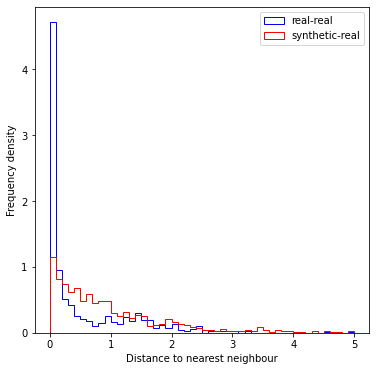

In [27]:
# Get nearest neighbour distances in real data
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_real_std)
dists, idxs = nn.kneighbors()
dist_real_real = dists.flatten()

# Get closest real data point to synthetic data points
dist_synthetic_real = synth_df['distance_to_closest_real'].values

# Plot histogram of distances to nearest real data point
bins = np.arange(0, 5.1, 0.1)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist(dist_real_real, bins=bins, histtype='step', color='b', 
        density=True, label='real-real')
ax.hist(dist_synthetic_real, bins=bins, histtype='step', color='r', 
        density=True, label='synthetic-real')

ax.set_xlabel('Distance to nearest neighbour')
ax.set_ylabel('Frequency density')
ax.legend()
plt.show()

Show general statistics

In [28]:
statistics = pd.DataFrame()
statistics['real-real data'] = pd.DataFrame(dist_real_real).describe()
statistics['real-synthetic data'] = pd.DataFrame(dist_synthetic_real).describe()
statistics

,real-real data,real-synthetic data
count,891.000000,891.000000
mean,0.561514,1.047574
std,1.170308,1.206917
min,0.000000,0.033606
25%,0.001592,0.269491
50%,0.152741,0.695202
75%,0.906723,1.384847
max,26.081659,11.994999


Note: In this case the average distance from a synthetic data point to it's nearest neighbour real data point is greater than the average distance from a real data point to it's nearest neighbour real data point.

Show counts of where there are nearest neighbour in real data is identical to points in real data or synthetic data.

In [29]:
count = np.sum(dist_real_real <0.001)
print (f'Number of data points in real data with identical nearest neighbour: {count}')

count = np.sum(dist_synthetic_real <0.001)
print (f'Number of data points in synthetic data with identical real data nearest neighbour: {count}')

Number of data points in real data with identical nearest neighbour: 213
Number of data points in synthetic data with identical real data nearest neighbour: 0


## Comparison of means and standard deviations of real and synthetic data

The charts below compare means and standard deviations of real and synthetic data, comparing passengers who survived or died separately.

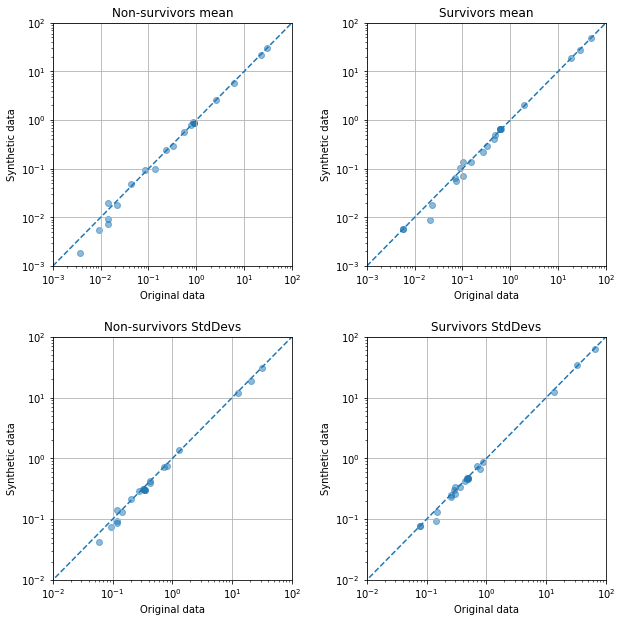

In [30]:
fig = plt.figure(figsize=(9,9))

# Compare means of patients who died
ax1 = fig.add_subplot(221)
mask = data['Survived'] == 0
x = data[mask][X_col_names].mean()
mask = synth_df['Survived'] == 0
y = synth_df[mask][X_col_names].mean()
ax1.scatter(x,y, alpha=0.5)
ax1.plot([0.001, 100],[0.001,100], linestyle='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-3, 1e2)
ax1.set_ylim(1e-3, 1e2)
ax1.set_xlabel('Original data')
ax1.set_ylabel('Synthetic data')
ax1.set_title('Non-survivors mean')
ax1.grid()

# Compare means of patients who survived
ax2 = fig.add_subplot(222)
mask = data['Survived'] == 1
x = data[mask][X_col_names].mean()
mask = synth_df['Survived'] == 1
y = synth_df[mask][X_col_names].mean()
ax2.scatter(x,y, alpha=0.5)
ax2.plot([0.001, 100],[0.001,100], linestyle='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-3, 1e2)
ax2.set_ylim(1e-3, 1e2)
ax2.set_xlabel('Original data')
ax2.set_ylabel('Synthetic data')
ax2.set_title('Survivors mean')
ax2.grid()

# Compare stdevs of patients who died
ax3 = fig.add_subplot(223)
mask = data['Survived'] == 0
x = data[mask][X_col_names].std()
mask = synth_df['Survived'] == 0
y = synth_df[mask][X_col_names].std()
ax3.scatter(x,y, alpha=0.5)
ax3.plot([0.001, 100],[0.001,100], linestyle='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(1e-2, 1e2)
ax3.set_ylim(1e-2, 1e2)
ax3.set_xlabel('Original data')
ax3.set_ylabel('Synthetic data')
ax3.set_title('Non-survivors StdDevs')
ax3.grid()

# Compare stdevs of patients who survived
ax4 = fig.add_subplot(224)
mask = data['Survived'] == 1
x = data[mask][X_col_names].std()
mask = synth_df['Survived'] == 1
y = synth_df[mask][X_col_names].std()
ax4.scatter(x,y, alpha=0.5)
ax4.plot([0.001, 100],[0.001,100], linestyle='--')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(1e-2, 1e2)
ax4.set_ylim(1e-2, 1e2)
ax4.set_xlabel('Original data')
ax4.set_ylabel('Synthetic data')
ax4.set_title('Survivors StdDevs')
ax4.grid()

plt.tight_layout(pad=2)
plt.savefig('images/smote_correls.png', facecolor='w', dpi=300)
plt.show()

## Test synthetic data for training a logistic regression model

Note that we create synethetic data using the training portion of our orginal train/test split. We then test the model on the original test data. The data used to create synthetic data is not present in the test data (this would cause leakage of test data into the training data and over-estimate performance).

### Fit model using synthetic data and check accuracy

In [31]:
# Get X data and standardised
X_synth = synth_df[X_col_names]
y_synth = synth_df['Survived'].values
X_synth_std, X_test_std = standardise_data(X_synth, X_test)

# Fit model
model_synth = LogisticRegression()
model_synth.fit(X_synth_std,y_synth)

# Get predictions of test set
y_pred_test_synth = model_synth.predict(X_test_std)

# Report accuracy
accuracy_test_synth = np.mean(y_pred_test_synth == y_test)

print (f'Accuracy of predicting test data from model trained on real data = {accuracy_test:0.3f}')
print (f'Accuracy of predicting test data from model trained on synthetic data = {accuracy_test_synth:0.3f}')

Accuracy of predicting test data from model trained on real data = 0.758
Accuracy of predicting test data from model trained on synthetic data = 0.753


### Receiver Operator Characteristic curves

In [32]:
y_probs = model.predict_proba(X_test_std)[:,1]
y_probs_synthetic = model_synth.predict_proba(X_test_std)[:,1]

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fpr_synth, tpr_synth, thresholds_synth = roc_curve(y_test, y_probs_synthetic)
roc_auc = auc(fpr, tpr)
roc_auc_snth = auc(fpr_synth, tpr_synth)
print (f'ROC AUC real training data: {roc_auc:0.2f}')
print (f'ROC AUC synthetic training data: {roc_auc_snth:0.2f}')

ROC AUC real training data: 0.79
ROC AUC synthetic training data: 0.78


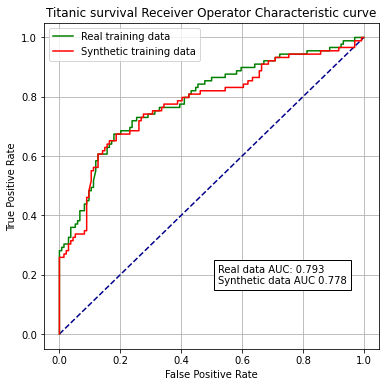

In [34]:
fig = plt.figure(figsize=(6,6))

# Plot ROC
ax1 = fig.add_subplot()
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Titanic survival Receiver Operator Characteristic curve')
ax1.plot(fpr,tpr, color='green', label = 'Real training data')
ax1.plot(fpr_synth,tpr_synth, color='red', label = 'Synthetic training data')
text = f'Real data AUC: {roc_auc:.3f}\nSynthetic data AUC {roc_auc_snth:.3f}'
ax1.text(0.52,0.17, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.legend()
plt.grid(True)

plt.savefig('images/synthetic_roc.png')
plt.show()

## Conclusions

Here we have used the SMOTE method to create synthetic data. We have removed any data points that are identical to the original data, and have also removed 10% of synthetic data points that are closest to original data.

Mean and standard deviations of the synthetic data are very similar to the original data. 

Synthetic trains a logistic regression model with minimal loss of accuracy when compared with training with original data.